# Reto: Oprtimizar la ubicación de productos

## Equipo - 6: The Three Engineers

| Nombre                        | Matrícula |
| :---------------------------- | :-------: |
| Rubén Pablo Barraza Maldonado | A01570838 |
| Rodrigo Zertuche López        | A00829401 |
| Arturo Garza Campuzano        | A00828096 |

## 1. Introducción

La colocación estratégica de productos en una tienda es crucial para maximizar la probabilidad de venta de productos relacionados. La problemática radica en asignar de manera óptima los productos a los pasillos. Por ello, se tiene la necesidad de utilizar técnicas de aprendizaje automático para analizar patrones de compra y optimizar la colocación de productos.

## 2. Importación y carga de datos

In [2]:
# Importar librerias
import math
import numpy as np
import pandas as pd
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from matplotlib.ticker import ScalarFormatter

# Lectura de datos
aisles_df = pd.read_csv('Data/aisles.csv')
departments_df = pd.read_csv('Data/departments.csv')
orders_df = pd.read_csv('Data/orders.csv')
order_products_prior_df = pd.read_csv('Data/order_products__prior.csv')
order_products_train_df = pd.read_csv('Data/order_products__train.csv')
products_df = pd.read_csv('Data/products.csv')

Los diferentes archivos que conforman el conjunto de datos fueron fusionados en un solo dataframe, con el fin de facilitar el análisis y visualización de todo el conjunto de datos.

In [2]:
# Agrupa los datos de las tablas en un solo data frame
order_products = pd.DataFrame()
# order_products = pd.concat([order_products_prior_df, order_products_train_df])
order_products = order_products_prior_df
order_products = order_products.merge(products_df, on = 'product_id', how = 'left')
order_products = order_products.merge(aisles_df, on = 'aisle_id', how = 'left')
order_products = order_products.merge(departments_df, on = 'department_id', how = 'left')
order_products = order_products.merge(orders_df, on = 'order_id', how = 'left')
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


## 3. Relación entre productos

### 3.1 K-Means Clustering

Se calcula la cantidad de veces que cada producto ha sido ordenado y se eliminan aquellos proudctos que hayan sido ordenados muy pocas veces; según el rango intercuartílico de la variable.

In [3]:
# Contar el numero de veces que cada producto ha sido ordenado
product_order_counts = order_products.groupby('product_id').size().reset_index(name='product_count')

# Mostrar estadisticos descriptivos
product_order_counts['product_count'].describe()

count     49685.000000
mean        680.670343
std        4987.769425
min           1.000000
25%          18.000000
50%          63.000000
75%         272.000000
max      491291.000000
Name: product_count, dtype: float64

In [4]:
# Calcular cuartiles
Q1 = product_order_counts['product_count'].quantile(0.25)
Q3 = product_order_counts['product_count'].quantile(0.75)

# Calcular el rango intercuartílico (IQR)
IQR = Q3 - Q1

# Definir los limites para detectar los outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Filtrar los datos para eliminar los outliers
product_order_counts_filtered = product_order_counts[(product_order_counts['product_count'] >= lower_limit) & (product_order_counts['product_count'] <= upper_limit)]

# Mostrar estadisticos descriptivos
product_order_counts_filtered['product_count'].describe()

count    42575.000000
mean       105.925919
std        139.891858
min          1.000000
25%         15.000000
50%         44.000000
75%        136.000000
max        653.000000
Name: product_count, dtype: float64

Se calcula la cantidad de productos comprados por cada usuario y se eliminan aquellos usuarios que hayan comprado muy pocos productos; según el rango intercuartílico de la variable.

In [5]:
# Contar la cantidad de productos comprados por cada usuario
productos_user_counts = order_products.groupby('user_id').size().reset_index(name='product_count')

productos_user_counts['product_count'].describe()

count    206209.000000
mean        164.004025
std         206.014923
min           3.000000
25%          44.000000
50%          90.000000
75%         196.000000
max        3725.000000
Name: product_count, dtype: float64

In [6]:
# Calcular cuartiles
Q1 = productos_user_counts['product_count'].quantile(0.25)
Q3 = productos_user_counts['product_count'].quantile(0.75)

# Calcular el rango intercuartílico (IQR)
IQR = Q3 - Q1

# Definir los límites para detectar los outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Filtrar los datos para eliminar los outliers
productos_user_counts_filtered = productos_user_counts[(productos_user_counts['product_count'] >= lower_limit) & (productos_user_counts['product_count'] <= upper_limit)]
productos_user_counts_filtered['product_count'].describe()

count    187868.000000
mean        112.208189
std          95.240992
min           3.000000
25%          41.000000
50%          80.000000
75%         156.000000
max         424.000000
Name: product_count, dtype: float64

Se filtra el dataframe principal para reducir la cantidad de registros.

In [7]:
# Obtener los conjuntos filtrados de productos y usuarios
filtered_product_ids = product_order_counts_filtered['product_id'].tolist()
filtered_user_ids = productos_user_counts_filtered['user_id'].tolist()

# Filtrar el dataframe original para incluir solo los que no son outliers
filtered_order_products = order_products[(order_products['product_id'].isin(filtered_product_ids)) & (order_products['user_id'].isin(filtered_user_ids))]

filtered_order_products.describe()

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.073472e+06,3.073472e+06,3.073472e+06,3.073472e+06,3.073472e+06,3.073472e+06,3.073472e+06,3.073472e+06,3.073472e+06,3.073472e+06,2.798691e+06
mean,1.712699e+06,2.472432e+04,7.999633e+00,3.766320e-01,6.791919e+01,1.144430e+01,1.033603e+05,9.922469e+00,2.833335e+00,1.359320e+01,1.391897e+01
std,9.872994e+05,1.427334e+04,6.771687e+00,4.845415e-01,3.837932e+01,6.066300e+00,5.947608e+04,9.729187e+00,2.085492e+00,4.239645e+00,9.752679e+00
min,1.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.578610e+05,1.253800e+04,3.000000e+00,0.000000e+00,3.700000e+01,7.000000e+00,5.182100e+04,3.000000e+00,1.000000e+00,1.100000e+01,6.000000e+00
50%,1.713001e+06,2.474600e+04,6.000000e+00,0.000000e+00,6.900000e+01,1.300000e+01,1.036110e+05,7.000000e+00,3.000000e+00,1.400000e+01,1.100000e+01
75%,2.568231e+06,3.699025e+04,1.100000e+01,1.000000e+00,1.030000e+02,1.700000e+01,1.548820e+05,1.300000e+01,5.000000e+00,1.700000e+01,2.200000e+01
max,3.421083e+06,4.968800e+04,1.020000e+02,1.000000e+00,1.340000e+02,2.100000e+01,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01


Se realiza un intento de elaborar una tabla con los usuarios y los productos que han comprado, especificando también su cantidad. No obstante, el kernel no pudo ejecutar la línea de código debido a su complejidad computacional: /var/folders/1l/48wfxxd93tx624h4f207pz180000gp/T/ipykernel_51289/2200060898.py:1: PerformanceWarning: The following operation may generate 7367292426 cells in the resulting pandas object. cross_order_product = pd.crosstab(filtered_order_products.user_id, filtered_order_products.product_id). Por lo tanto, no es posible realizar un agrupamiento de usuarios y producto específicos para este conjunto de datos. Sin embargo, se propone realizar el agrupamiento a nivel pasillo y departamento; con el propósito de identificar a los distintos grupos de usuarios.

In [8]:
# cross_order_product = pd.crosstab(filtered_order_products.user_id, filtered_order_products.product_id)
# cross_order_product.tail(20)

In [9]:
# Agrupar los usuarios junto con los pasillos y los departamentos para categorizarlos.
cross_order_product = pd.crosstab(order_products.user_id, order_products.aisle)
cross_order_product.describe()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
count,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,...,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000
mean,0.101441,0.841932,0.041055,0.043204,1.918704,0.176384,1.647746,0.120198,0.031303,0.244878,...,1.462119,1.254635,0.652721,0.977891,0.179687,0.163436,0.228060,4.258544,0.153466,7.310947
std,0.751576,2.481919,0.541937,0.377655,11.319803,1.133834,3.876985,0.586719,0.278195,3.092074,...,3.498000,5.397518,3.381307,2.883605,1.326959,0.780867,1.126471,11.465223,1.770348,18.661955
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000,0.000000,7.000000
max,54.000000,107.000000,47.000000,27.000000,819.000000,63.000000,160.000000,69.000000,27.000000,541.000000,...,130.000000,382.000000,241.000000,103.000000,83.000000,71.000000,72.000000,519.000000,164.000000,1540.000000


In [10]:
normalaize_df = cross_order_product.div(cross_order_product.sum(axis=1), axis=0)
normalaize_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.014286,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.028571
2,0.000000,0.013274,0.0,0.0,0.0,0.0,0.00885,0.0,0.0,0.0,...,0.013274,0.004425,0.004425,0.000000,0.0,0.0,0.0,0.008850,0.0,0.185841
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.045455,0.011364,0.000000,0.000000,0.0,0.0,0.0,0.022727,0.0,0.000000
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.055556,0.0,0.0,0.0,0.055556,0.0,0.000000
5,0.021739,0.086957,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.065217


In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca_df = pca.fit_transform(normalaize_df)
pca_df = pd.DataFrame(pca_df)
pca_df.tail()

,0,1,2,3,4,5,6,7,8,9
206204,0.001716,0.084855,-0.065398,-0.068637,0.114987,-0.028520,0.020690,0.023922,-0.027230,-0.016863
206205,-0.089658,-0.046734,-0.048290,0.012789,-0.059589,-0.000558,-0.013966,-0.042892,0.142733,-0.060334
206206,-0.024827,-0.013520,-0.003968,-0.030920,0.032990,0.020686,0.037631,0.032880,-0.022895,-0.002488
206207,-0.009310,-0.003375,-0.045594,-0.012231,0.013768,0.055686,0.008147,0.029481,-0.010378,0.020686
206208,-0.066755,0.044041,-0.049675,-0.005734,-0.045202,-0.019119,-0.009835,0.040051,-0.026820,0.014938


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

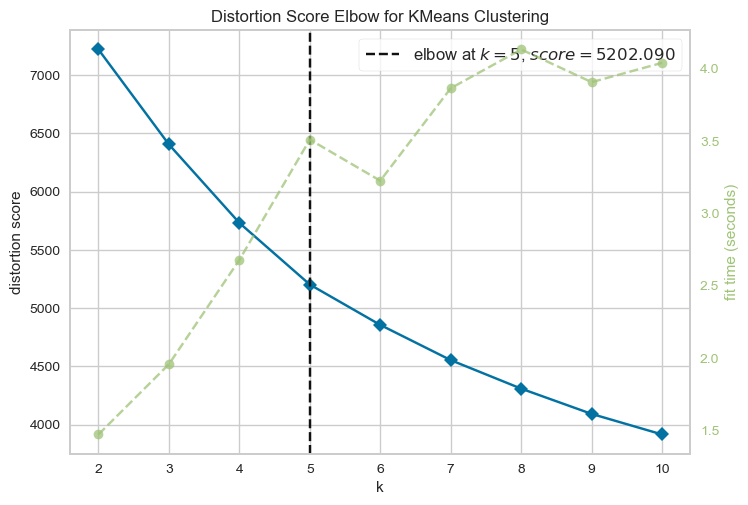

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

elbow_chart = KElbowVisualizer(KMeans(),k=10)
elbow_chart.fit(pca_df)
elbow_chart.show()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


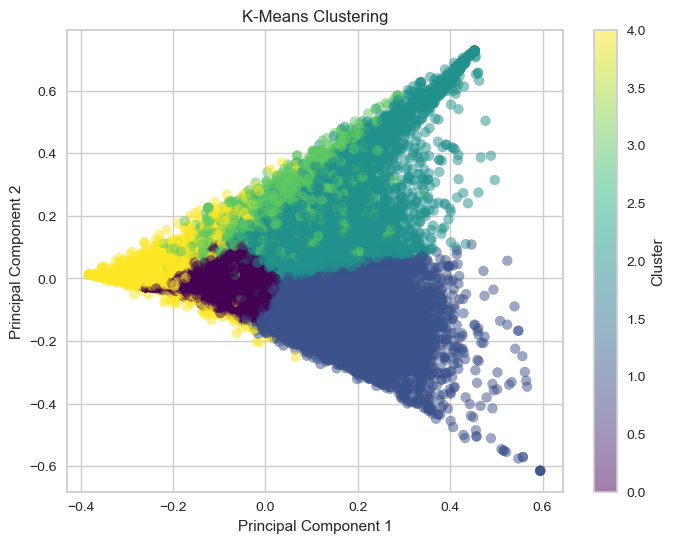

In [13]:
from sklearn.cluster import KMeans
#Initialize the class object
kmeans = KMeans(n_clusters= 5, random_state=42)

#predict the labels of clusters.
label = kmeans.fit(pca_df)

cluster_labels = kmeans.labels_
len(cluster_labels)

pred = kmeans.predict(pca_df)

# Plotting the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_df[0], pca_df[1], c=cluster_labels, cmap='viridis', marker='o', alpha=0.5)
plt.title('K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [14]:
cross_order_product['cluster'] = pred
cluster1 = cross_order_product[cross_order_product.cluster == 0]
cluster1.drop('cluster', axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     10.015395
fresh vegetables                  7.834430
yogurt                            7.407982
packaged vegetables fruits        6.191993
packaged cheese                   5.114631
chips pretzels                    4.685163
milk                              4.376213
water seltzer sparkling water     4.256471
refrigerated                      3.381599
ice cream ice                     3.243310
dtype: float64

In [15]:
cross_order_product['cluster'] = pred
cluster1 = cross_order_product[cross_order_product.cluster == 1]
cluster1.drop('cluster', axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 38.560509
fresh fruits                     22.506154
packaged vegetables fruits       12.489120
yogurt                            6.374697
packaged cheese                   5.211453
fresh herbs                       4.323289
milk                              4.127325
soy lactosefree                   3.847753
frozen produce                    3.433885
water seltzer sparkling water     3.204086
dtype: float64

In [16]:
cross_order_product['cluster'] = pred
cluster1 = cross_order_product[cross_order_product.cluster == 2]
cluster1.drop('cluster', axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     37.035344
fresh vegetables                 15.954360
packaged vegetables fruits       12.768523
yogurt                           10.446075
milk                              6.242720
packaged cheese                   5.434114
soy lactosefree                   3.975720
water seltzer sparkling water     3.804482
bread                             3.374645
chips pretzels                    3.296248
dtype: float64

In [17]:
cross_order_product['cluster'] = pred
cluster1 = cross_order_product[cross_order_product.cluster == 3]
cluster1.drop('cluster', axis=1).mean().sort_values(ascending=False)[0:10]

aisle
packaged produce                 19.076133
fresh fruits                     11.543451
packaged vegetables fruits        4.460758
fresh vegetables                  3.251300
water seltzer sparkling water     1.834365
milk                              1.693612
packaged cheese                   1.617851
chips pretzels                    1.195964
frozen produce                    1.193984
nuts seeds dried fruit            1.087150
dtype: float64

In [18]:
cross_order_product['cluster'] = pred
cluster1 = cross_order_product[cross_order_product.cluster == 4]
cluster1.drop('cluster', axis=1).mean().sort_values(ascending=False)[0:10]

aisle
water seltzer sparkling water    22.026967
fresh fruits                      3.534171
soft drinks                       3.005911
yogurt                            2.353713
energy granola bars               1.636867
chips pretzels                    1.445696
tea                               1.415774
milk                              1.400259
packaged vegetables fruits        1.336350
soy lactosefree                   1.151644
dtype: float64

### 3.2 Market Basket Analysis with Association Rules

In [3]:
transaction_groups = order_products.groupby('order_id')['product_name']

transaction_groups.head()


0                                     Organic Egg Whites
1                                  Michigan Organic Kale
2                                          Garlic Powder
3                                         Coconut Butter
4                                      Natural Sweetener
                                ...                     
32434479                       Freeze Dried Mango Slices
32434480                 Purple Carrot & blueberry Puffs
32434481        Organic Mixed Berry Yogurt & Fruit Snack
32434482         Organic Strawberry Yogurt & Fruit Snack
32434483    Organic Strawberry & Mango Dried Tiny Fruits
Name: product_name, Length: 14250264, dtype: object

In [4]:
# Assuming your DataFrame is named df
# Select only the 'order_id' and 'product_name' columns
order_product_names = order_products[['order_id', 'product_name']]

# Display the resulting DataFrame
print(order_product_names)

          order_id                                       product_name
0                2                                 Organic Egg Whites
1                2                              Michigan Organic Kale
2                2                                      Garlic Powder
3                2                                     Coconut Butter
4                2                                  Natural Sweetener
...            ...                                                ...
32434484   3421083          Free & Clear Natural Dishwasher Detergent
32434485   3421083       Organic Mini Sandwich Crackers Peanut Butter
32434486   3421083                    All Natural French Toast Sticks
32434487   3421083                                             Banana
32434488   3421083  Organic  Sweet & Salty Peanut Pretzel Granola ...

[32434489 rows x 2 columns]


In [5]:
# Group by 'order_id' and aggregate 'product_name' into arrays
order_product_arrays = order_product_names.groupby('order_id')['product_name'].apply(list)

# Display the resulting Series
print(order_product_arrays)

order_id
2          [Organic Egg Whites, Michigan Organic Kale, Ga...
3          [Total 2% with Strawberry Lowfat Greek Straine...
4          [Plain Pre-Sliced Bagels, Honey/Lemon Cough Dr...
5          [Bag of Organic Bananas, Just Crisp, Parmesan,...
6          [Cleanse, Dryer Sheets Geranium Scent, Clean D...
                                 ...                        
3421079                                      [Moisture Soap]
3421080    [Organic Whole Milk, Vanilla Bean Ice Cream, O...
3421081    [Hint of Lime Flavored Tortilla Chips, Classic...
3421082    [Fresh 99% Lean Ground Turkey, Original Spray,...
3421083    [Freeze Dried Mango Slices, Purple Carrot & bl...
Name: product_name, Length: 3214874, dtype: object


In [6]:
order_product_list = order_product_arrays.tolist()

In [7]:
from mlxtend.preprocessing import TransactionEncoder

encoder = TransactionEncoder()
transactions = encoder.fit(order_product_list)

In [8]:
itemsets = transactions.transform(order_product_list)
itemsets

: 

Solución de Ruben

In [1]:
tbl = order_products.groupby(['order_id', 'product_name']).agg({'product_id':'count'}).reset_index()
tbl = tbl.pivot_table(index='order_id', columns='product_name', values='product_id')
tbl = tbl.fillna(False)
tbl

NameError: name 'order_products' is not defined

In [5]:
tbl.replace(1.0, True, inplace=True)

In [6]:
tbl

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
order_id,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3421079,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3421080,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3421081,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [3]:
transaction_groups = order_products.groupby('order_id')['aisle_id']
order_product_names = order_products[['order_id', 'aisle_id']]
order_product_arrays = order_product_names.groupby('order_id')['aisle_id'].apply(list)
order_product_list = order_product_arrays.tolist()

In [4]:
from mlxtend.preprocessing import TransactionEncoder

encoder = TransactionEncoder()
transactions = encoder.fit(order_product_list)
itemsets = transactions.transform(order_product_list)
itemsets

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False]])